#  Long Short-Term Memory model for local temperature predictions
## By Eva Bendix Nielsen,
## For master thesis: Predicting Climate with Machine learning


In this study a Long Short-Term Memory (LSTM) model is used to predict the annual winter local temperature for Europe given the global value of total solar irradiance, carbon dioxide and the volcaninc areosol. 

Keras is used for building the model. 

In [4]:
import keras.layers 
import keras.models
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, LSTM
from keras.optimizers import Adam 
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


Before loading the dataset some values needs to be defined. This includes the batch size, the epoch and much more.

In [5]:
location = 3                        # Choose on of the 11 locations for prediction 
batch_s = 10                        # The batch size since it is a statefull LSTM it is equal to the input size 
year_end = 500                      # The amount of year for training 
year_end_shifted = year_end +1      # The last year for a shifted model
test_train_split = 460              # The years for trining
training_epoch = 1600               # The amount of training epochs 

Then the data is loaded. The file DATA_DK_1500_2000_DK_GB.csv contains the values for the three climate drivers. The file 'DATA_EUROPE_1500_2000.csv' contains the winter tempersature for 11 locations in Eurpoe. The data are divided into a test and training set before scaling to hinder bias in the test set. The temperature is made into two dataset one from 1500 to 1999 and one from 1501 to 2000. This is nedded since the output is the temperture the following year hence a temperature shifted one year ahead. 

In [6]:
# Loading data and parameters
dataset = read_csv('DATA_DK_1500_2000_DK_GB.csv', header=None, index_col=0)
values = dataset.values
values = np.flip(values,0) 

# Loading the temperature
dataset1 = read_csv('DATA_EUROPE_1500_2000.csv', header=None, index_col=0)
values1 = dataset1.values

# Dividing temperature into test and train for both shifted and non shifted
T_train = values1[0:test_train_split, location:location+1]
T_test = values1[test_train_split:year_end,location:location+1]

T_train_shifted= values1[1:test_train_split+1,location:location+1]
T_test_shifted= values1[test_train_split+1:year_end_shifted,location:location+1]


# Dividing climate driver into test and train for both shifted and non shifted
P_train = values[1:test_train_split+1,0:3]
P_test = values[test_train_split+1:year_end_shifted,0:3]


print('Dimensions of training set:')
print(T_train.shape)
print('And of test set: ')
print(T_test.shape)


Dimensions of training set:
(460, 1)
And of test set: 
(40, 1)


The  next step is to scale the temperature, shifted temperature and climate drivers individual to a value between 0 and 1 using MinMaxScaler from Scikit-learn.

In [7]:
# Scaling tempperature
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(T_train)
T_train_scaled = scaler.transform(T_train)
T_test_scaled = scaler.transform(T_test)


# Scaling shifted tempperature
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1 = scaler1.fit(T_train_shifted)
T_train_shifted_scaled = scaler1.transform(T_train_shifted)
T_test_shifted_scaled = scaler1.transform(T_test_shifted)

# Scaling climate drivers
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(P_train)
P_train_scaled = scaler2.transform(P_train)
P_test_scaled = scaler2.transform(P_test)


## Shaping the input 
The input in the LSTM model is a 3D tensor with the shape: (samples, batch, channels). Channels is the number of features where temperature for instant is one feature. The next step is therefore to shape the training and test set into this dimension and creating a sliding window for more batches to train on. The shifted temperature needs to have the same amount of batches for the model to know the right result. This is therefore also defined.

In [8]:
# Setting the climate drivers and the non-shifted temperature in the same matrix to use as input
TP_train = np.hstack((P_train_scaled,T_train_scaled))
TP_test = np.hstack((P_test_scaled, T_test_scaled))

# Creating a sliding window
Shift=5                        # how big an overlap in batch

Batch_n = (test_train_split-batch_s)//Shift    # Number of new batches

# Creating an empty tensor to fill with the new batches
TP_train_B = np.zeros((Batch_n, batch_s, 4))         # B is for batch
TT_train_shifted_B = np.zeros((Batch_n,batch_s, 1))
   
# Defining the new batches and inserting them in the tensor 
for i in range(Batch_n): 
    g = i*Shift
    TP_train_B[i,:,:] = TP_train[g:g+batch_s,:]                         # For climate drivers and temperature 
    TT_train_shifted_B [i,:,:] = T_train_shifted_scaled[g:g+batch_s,:]  # For shifted temperature 
    
    
print('Dimensions of training input:')
print(TP_train_B.shape)
print('And dimension of temperature for trainin the model (shifted temperature): ')
print(TT_train_shifted_B.shape)

Dimensions of training input:
(90, 10, 4)
And dimension of temperature for trainin the model (shifted temperature): 
(90, 10, 1)


The correct tensors are now created for training the model. The training have 4 channels which is the 3 climate drivers and the temperature for the previous years which can be defined as x. The shifted temperature have one channel which is the temperature for the year the model shall predict, which can be defined as y. The next step is to create a model that makes the mapping f(x)=y.

## Defining the architecture 

The architecture now needs to be defined and it is structured as shown in the table below.
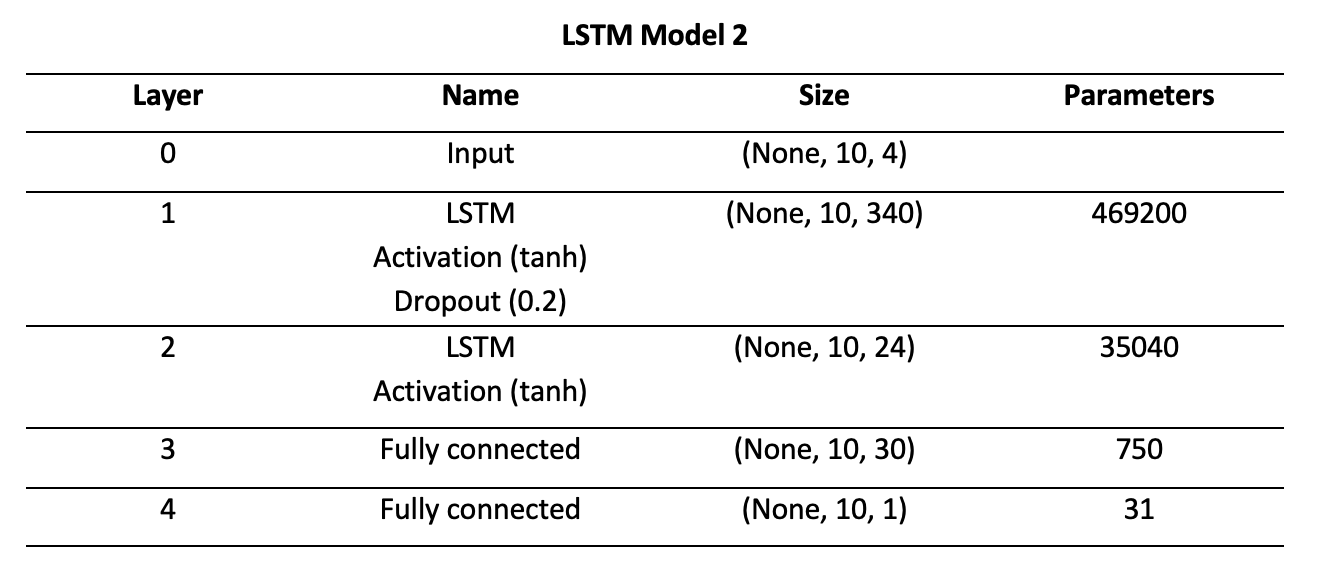

In [9]:
input_s = (10,4)    # The input shape 

model = Sequential()
model.add(LSTM(340, input_shape=input_s, return_sequences=True, dropout=0.2)) 
model.add(LSTM(24, return_sequences=True)) 
model.add(Dense(30))
model.add(Dense(1))

adam = Adam(lr=0.000001) # Defining the learning rate 

model.compile(loss='mse', optimizer=adam, metrics=['mean_squared_error'])

The next step is to train the model using the previusly defined inputs. Almost 10 years is removed from the trainig input for validating the model. This step may take a while for faster but worse lerning set number on epoch lower. 


In [10]:
# defining validation set
Val_batch=Batch_n-(10//Shift)

x_val = TP_train_B[Val_batch:, ::, ::]
y_val = TT_train_shifted_B[Val_batch:, ::, ::]

# removing validation from trainingset 
x_train = TP_train_B[:Val_batch, ::, ::]
y_train = TT_train_shifted_B[:Val_batch, ::, ::]



# Training the model
history = model.fit(x_train,y_train , validation_data=(x_val,y_val) , batch_size=batch_s, epochs=training_epoch, shuffle=False) 

Train on 88 samples, validate on 2 samples
Epoch 1/1600
88/88 [==============================] - 2s 18ms/step - loss: 0.3685 - mean_squared_error: 0.3685 - val_loss: 0.3984 - val_mean_squared_error: 0.3984
Epoch 2/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3697 - mean_squared_error: 0.3697 - val_loss: 0.3967 - val_mean_squared_error: 0.3967
Epoch 3/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3685 - mean_squared_error: 0.3685 - val_loss: 0.3949 - val_mean_squared_error: 0.3949
Epoch 4/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3668 - mean_squared_error: 0.3668 - val_loss: 0.3931 - val_mean_squared_error: 0.3931
Epoch 5/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3652 - mean_squared_error: 0.3652 - val_loss: 0.3914 - val_mean_squared_error: 0.3914
Epoch 6/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3653 - mean_squared_error: 0.3653 - val_loss: 0.3896 - val_mean_square

88/88 [==============================] - 0s 2ms/step - loss: 0.3180 - mean_squared_error: 0.3180 - val_loss: 0.3202 - val_mean_squared_error: 0.3202
Epoch 52/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3149 - mean_squared_error: 0.3149 - val_loss: 0.3188 - val_mean_squared_error: 0.3188
Epoch 53/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3160 - mean_squared_error: 0.3160 - val_loss: 0.3174 - val_mean_squared_error: 0.3174
Epoch 54/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3128 - mean_squared_error: 0.3128 - val_loss: 0.3160 - val_mean_squared_error: 0.3160
Epoch 55/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3118 - mean_squared_error: 0.3118 - val_loss: 0.3145 - val_mean_squared_error: 0.3145
Epoch 56/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.3108 - mean_squared_error: 0.3108 - val_loss: 0.3131 - val_mean_squared_error: 0.3131
Epoch 57/1600
88/88 [===============

88/88 [==============================] - 0s 2ms/step - loss: 0.2707 - mean_squared_error: 0.2707 - val_loss: 0.2543 - val_mean_squared_error: 0.2543
Epoch 102/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2672 - mean_squared_error: 0.2672 - val_loss: 0.2531 - val_mean_squared_error: 0.2531
Epoch 103/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2686 - mean_squared_error: 0.2686 - val_loss: 0.2519 - val_mean_squared_error: 0.2519
Epoch 104/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2661 - mean_squared_error: 0.2661 - val_loss: 0.2507 - val_mean_squared_error: 0.2507
Epoch 105/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2688 - mean_squared_error: 0.2688 - val_loss: 0.2496 - val_mean_squared_error: 0.2496
Epoch 106/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2667 - mean_squared_error: 0.2667 - val_loss: 0.2484 - val_mean_squared_error: 0.2484
Epoch 107/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.2316 - mean_squared_error: 0.2316 - val_loss: 0.2005 - val_mean_squared_error: 0.2005
Epoch 152/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2346 - mean_squared_error: 0.2346 - val_loss: 0.1996 - val_mean_squared_error: 0.1996
Epoch 153/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2358 - mean_squared_error: 0.2358 - val_loss: 0.1987 - val_mean_squared_error: 0.1987
Epoch 154/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2329 - mean_squared_error: 0.2329 - val_loss: 0.1978 - val_mean_squared_error: 0.1978
Epoch 155/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2336 - mean_squared_error: 0.2336 - val_loss: 0.1969 - val_mean_squared_error: 0.1969
Epoch 156/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2297 - mean_squared_error: 0.2297 - val_loss: 0.1960 - val_mean_squared_error: 0.1960
Epoch 157/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.1604 - val_mean_squared_error: 0.1604
Epoch 202/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1948 - mean_squared_error: 0.1948 - val_loss: 0.1598 - val_mean_squared_error: 0.1598
Epoch 203/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.1591 - val_mean_squared_error: 0.1591
Epoch 204/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1957 - mean_squared_error: 0.1957 - val_loss: 0.1585 - val_mean_squared_error: 0.1585
Epoch 205/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1987 - mean_squared_error: 0.1987 - val_loss: 0.1578 - val_mean_squared_error: 0.1578
Epoch 206/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 0.1572 - val_mean_squared_error: 0.1572
Epoch 207/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1805 - mean_squared_error: 0.1805 - val_loss: 0.1346 - val_mean_squared_error: 0.1346
Epoch 252/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1712 - mean_squared_error: 0.1712 - val_loss: 0.1343 - val_mean_squared_error: 0.1343
Epoch 253/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1751 - mean_squared_error: 0.1751 - val_loss: 0.1339 - val_mean_squared_error: 0.1339
Epoch 254/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1815 - mean_squared_error: 0.1815 - val_loss: 0.1336 - val_mean_squared_error: 0.1336
Epoch 255/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1761 - mean_squared_error: 0.1761 - val_loss: 0.1332 - val_mean_squared_error: 0.1332
Epoch 256/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1732 - mean_squared_error: 0.1732 - val_loss: 0.1329 - val_mean_squared_error: 0.1329
Epoch 257/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - val_loss: 0.1223 - val_mean_squared_error: 0.1223
Epoch 302/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1575 - mean_squared_error: 0.1575 - val_loss: 0.1222 - val_mean_squared_error: 0.1222
Epoch 303/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1220 - val_mean_squared_error: 0.1220
Epoch 304/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1643 - mean_squared_error: 0.1643 - val_loss: 0.1219 - val_mean_squared_error: 0.1219
Epoch 305/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1549 - mean_squared_error: 0.1549 - val_loss: 0.1217 - val_mean_squared_error: 0.1217
Epoch 306/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1580 - mean_squared_error: 0.1580 - val_loss: 0.1216 - val_mean_squared_error: 0.1216
Epoch 307/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1475 - mean_squared_error: 0.1475 - val_loss: 0.1177 - val_mean_squared_error: 0.1177
Epoch 352/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1488 - mean_squared_error: 0.1488 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 353/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 354/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1486 - mean_squared_error: 0.1486 - val_loss: 0.1175 - val_mean_squared_error: 0.1175
Epoch 355/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1552 - mean_squared_error: 0.1552 - val_loss: 0.1174 - val_mean_squared_error: 0.1174
Epoch 356/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1461 - mean_squared_error: 0.1461 - val_loss: 0.1174 - val_mean_squared_error: 0.1174
Epoch 357/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1447 - mean_squared_error: 0.1447 - val_loss: 0.1150 - val_mean_squared_error: 0.1150
Epoch 402/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1398 - mean_squared_error: 0.1398 - val_loss: 0.1149 - val_mean_squared_error: 0.1149
Epoch 403/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.1148 - val_mean_squared_error: 0.1148
Epoch 404/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1426 - mean_squared_error: 0.1426 - val_loss: 0.1148 - val_mean_squared_error: 0.1148
Epoch 405/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - val_loss: 0.1147 - val_mean_squared_error: 0.1147
Epoch 406/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1449 - mean_squared_error: 0.1449 - val_loss: 0.1146 - val_mean_squared_error: 0.1146
Epoch 407/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1115 - val_mean_squared_error: 0.1115
Epoch 452/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1348 - mean_squared_error: 0.1348 - val_loss: 0.1114 - val_mean_squared_error: 0.1114
Epoch 453/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1359 - mean_squared_error: 0.1359 - val_loss: 0.1113 - val_mean_squared_error: 0.1113
Epoch 454/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1384 - mean_squared_error: 0.1384 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 455/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1111 - val_mean_squared_error: 0.1111
Epoch 456/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1358 - mean_squared_error: 0.1358 - val_loss: 0.1110 - val_mean_squared_error: 0.1110
Epoch 457/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1351 - mean_squared_error: 0.1351 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 502/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 0.1073 - val_mean_squared_error: 0.1073
Epoch 503/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1312 - mean_squared_error: 0.1312 - val_loss: 0.1073 - val_mean_squared_error: 0.1073
Epoch 504/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1365 - mean_squared_error: 0.1365 - val_loss: 0.1072 - val_mean_squared_error: 0.1072
Epoch 505/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 506/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1306 - mean_squared_error: 0.1306 - val_loss: 0.1070 - val_mean_squared_error: 0.1070
Epoch 507/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1031 - val_mean_squared_error: 0.1031
Epoch 552/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1030 - val_mean_squared_error: 0.1030
Epoch 553/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - val_loss: 0.1029 - val_mean_squared_error: 0.1029
Epoch 554/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1245 - mean_squared_error: 0.1245 - val_loss: 0.1028 - val_mean_squared_error: 0.1028
Epoch 555/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.1028 - val_mean_squared_error: 0.1028
Epoch 556/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.1027 - val_mean_squared_error: 0.1027
Epoch 557/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1267 - mean_squared_error: 0.1267 - val_loss: 0.0987 - val_mean_squared_error: 0.0987
Epoch 602/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1238 - mean_squared_error: 0.1238 - val_loss: 0.0986 - val_mean_squared_error: 0.0986
Epoch 603/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.0985 - val_mean_squared_error: 0.0985
Epoch 604/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.0984 - val_mean_squared_error: 0.0984
Epoch 605/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.0983 - val_mean_squared_error: 0.0983
Epoch 606/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1216 - mean_squared_error: 0.1216 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
Epoch 607/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.0940 - val_mean_squared_error: 0.0940
Epoch 652/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.0939 - val_mean_squared_error: 0.0939
Epoch 653/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1239 - mean_squared_error: 0.1239 - val_loss: 0.0938 - val_mean_squared_error: 0.0938
Epoch 654/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1166 - mean_squared_error: 0.1166 - val_loss: 0.0937 - val_mean_squared_error: 0.0937
Epoch 655/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.0936 - val_mean_squared_error: 0.0936
Epoch 656/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.0934 - val_mean_squared_error: 0.0934
Epoch 657/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1156 - mean_squared_error: 0.1156 - val_loss: 0.0896 - val_mean_squared_error: 0.0896
Epoch 702/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - val_loss: 0.0895 - val_mean_squared_error: 0.0895
Epoch 703/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1162 - mean_squared_error: 0.1162 - val_loss: 0.0894 - val_mean_squared_error: 0.0894
Epoch 704/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1157 - mean_squared_error: 0.1157 - val_loss: 0.0893 - val_mean_squared_error: 0.0893
Epoch 705/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1149 - mean_squared_error: 0.1149 - val_loss: 0.0892 - val_mean_squared_error: 0.0892
Epoch 706/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1168 - mean_squared_error: 0.1168 - val_loss: 0.0892 - val_mean_squared_error: 0.0892
Epoch 707/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1093 - mean_squared_error: 0.1093 - val_loss: 0.0853 - val_mean_squared_error: 0.0853
Epoch 752/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 753/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1083 - mean_squared_error: 0.1083 - val_loss: 0.0851 - val_mean_squared_error: 0.0851
Epoch 754/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1091 - mean_squared_error: 0.1091 - val_loss: 0.0851 - val_mean_squared_error: 0.0851
Epoch 755/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.0850 - val_mean_squared_error: 0.0850
Epoch 756/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1096 - mean_squared_error: 0.1096 - val_loss: 0.0849 - val_mean_squared_error: 0.0849
Epoch 757/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1054 - mean_squared_error: 0.1054 - val_loss: 0.0809 - val_mean_squared_error: 0.0809
Epoch 802/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1052 - mean_squared_error: 0.1052 - val_loss: 0.0808 - val_mean_squared_error: 0.0808
Epoch 803/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1035 - mean_squared_error: 0.1035 - val_loss: 0.0807 - val_mean_squared_error: 0.0807
Epoch 804/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1024 - mean_squared_error: 0.1024 - val_loss: 0.0806 - val_mean_squared_error: 0.0806
Epoch 805/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1054 - mean_squared_error: 0.1054 - val_loss: 0.0805 - val_mean_squared_error: 0.0805
Epoch 806/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1036 - mean_squared_error: 0.1036 - val_loss: 0.0804 - val_mean_squared_error: 0.0804
Epoch 807/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.1010 - mean_squared_error: 0.1010 - val_loss: 0.0766 - val_mean_squared_error: 0.0766
Epoch 852/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1054 - mean_squared_error: 0.1054 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 853/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0989 - mean_squared_error: 0.0989 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 854/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1024 - mean_squared_error: 0.1024 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 855/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1029 - mean_squared_error: 0.1029 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 856/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.1056 - mean_squared_error: 0.1056 - val_loss: 0.0762 - val_mean_squared_error: 0.0762
Epoch 857/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.0992 - mean_squared_error: 0.0992 - val_loss: 0.0728 - val_mean_squared_error: 0.0728
Epoch 902/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0727 - val_mean_squared_error: 0.0727
Epoch 903/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 904/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 905/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - val_loss: 0.0724 - val_mean_squared_error: 0.0724
Epoch 906/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0967 - mean_squared_error: 0.0967 - val_loss: 0.0724 - val_mean_squared_error: 0.0724
Epoch 907/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.0935 - mean_squared_error: 0.0935 - val_loss: 0.0689 - val_mean_squared_error: 0.0689
Epoch 952/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0688 - val_mean_squared_error: 0.0688
Epoch 953/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0947 - mean_squared_error: 0.0947 - val_loss: 0.0687 - val_mean_squared_error: 0.0687
Epoch 954/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0995 - mean_squared_error: 0.0995 - val_loss: 0.0687 - val_mean_squared_error: 0.0687
Epoch 955/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0971 - mean_squared_error: 0.0971 - val_loss: 0.0686 - val_mean_squared_error: 0.0686
Epoch 956/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 957/1600
88/88 [=========

88/88 [==============================] - 0s 2ms/step - loss: 0.0924 - mean_squared_error: 0.0924 - val_loss: 0.0651 - val_mean_squared_error: 0.0651
Epoch 1002/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0925 - mean_squared_error: 0.0925 - val_loss: 0.0651 - val_mean_squared_error: 0.0651
Epoch 1003/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - val_loss: 0.0650 - val_mean_squared_error: 0.0650
Epoch 1004/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0650 - val_mean_squared_error: 0.0650
Epoch 1005/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 1006/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0648 - val_mean_squared_error: 0.0648
Epoch 1007/1600
88/88 [===

Epoch 1051/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 1052/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0849 - mean_squared_error: 0.0849 - val_loss: 0.0618 - val_mean_squared_error: 0.0618
Epoch 1053/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - val_loss: 0.0618 - val_mean_squared_error: 0.0618
Epoch 1054/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - val_loss: 0.0617 - val_mean_squared_error: 0.0617
Epoch 1055/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0616 - val_mean_squared_error: 0.0616
Epoch 1056/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0863 - mean_squared_error: 0.0863 - val_loss: 0.0615 - val_mean_squared_error: 0.0615
Epoch 1057

88/88 [==============================] - 0s 2ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 1101/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0848 - mean_squared_error: 0.0848 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 1102/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - val_loss: 0.0587 - val_mean_squared_error: 0.0587
Epoch 1103/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0815 - mean_squared_error: 0.0815 - val_loss: 0.0586 - val_mean_squared_error: 0.0586
Epoch 1104/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0819 - mean_squared_error: 0.0819 - val_loss: 0.0585 - val_mean_squared_error: 0.0585
Epoch 1105/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0796 - mean_squared_error: 0.0796 - val_loss: 0.0584 - val_mean_squared_error: 0.0584
Epoch 1106/1600
88/88 [===

Epoch 1150/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0793 - mean_squared_error: 0.0793 - val_loss: 0.0561 - val_mean_squared_error: 0.0561
Epoch 1151/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0825 - mean_squared_error: 0.0825 - val_loss: 0.0561 - val_mean_squared_error: 0.0561
Epoch 1152/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0793 - mean_squared_error: 0.0793 - val_loss: 0.0560 - val_mean_squared_error: 0.0560
Epoch 1153/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - val_loss: 0.0560 - val_mean_squared_error: 0.0560
Epoch 1154/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - val_loss: 0.0560 - val_mean_squared_error: 0.0560
Epoch 1155/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.0559 - val_mean_squared_error: 0.0559
Epoch 1156

88/88 [==============================] - 0s 2ms/step - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 1200/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 1201/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 1202/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 1203/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0795 - mean_squared_error: 0.0795 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 1204/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0774 - mean_squared_error: 0.0774 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 1205/1600
88/88 [===

Epoch 1249/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0760 - mean_squared_error: 0.0760 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 1250/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0771 - mean_squared_error: 0.0771 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 1251/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 1252/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 1253/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0748 - mean_squared_error: 0.0748 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 1254/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0716 - mean_squared_error: 0.0716 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 1255

88/88 [==============================] - 0s 2ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 1299/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 1300/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 1301/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0735 - mean_squared_error: 0.0735 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 1302/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0713 - mean_squared_error: 0.0713 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 1303/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 1304/1600
88/88 [===

Epoch 1348/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 1349/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 0.0490 - val_mean_squared_error: 0.0490
Epoch 1350/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 1351/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 1352/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 1353/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 1354

88/88 [==============================] - 0s 2ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 1398/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 1399/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 1400/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 1401/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0663 - mean_squared_error: 0.0663 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 1402/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 1403/1600
88/88 [===

Epoch 1447/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0656 - mean_squared_error: 0.0656 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 1448/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 1449/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0653 - mean_squared_error: 0.0653 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 1450/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 1451/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 1452/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 1453

88/88 [==============================] - 0s 2ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 1497/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0651 - mean_squared_error: 0.0651 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 1498/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 1499/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 1500/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 1501/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 1502/1600
88/88 [===

Epoch 1546/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 1547/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 1548/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 1549/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 1550/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 1551/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0633 - mean_squared_error: 0.0633 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 1552

88/88 [==============================] - 0s 2ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1596/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1597/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1598/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1599/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 1600/1600
88/88 [==============================] - 0s 2ms/step - loss: 0.0619 - mean_squared_error: 0.0619 - val_loss: 0.0459 - val_mean_squared_error: 0.0459


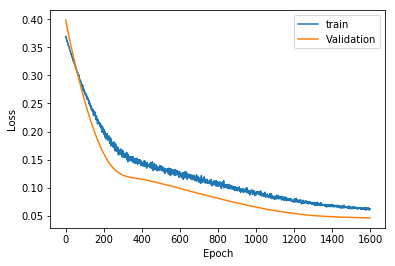

In [11]:
pyplot.figure()
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['train', 'Validation'])
pyplot.show()

Now the model have trained and the loss function for the training and validation set is graphed above.

# Predicting and plotting temperatures 
Since the model has trained a prediction can be made on the test set. The next  illustartes the way of predicting the temperature described as LSTM model 2 were the correct temperatures are provided for the first 10 years and then the model is predicting based on its own predictions. 

In [12]:
which = 0
Prior = 10                   # Gives the 10 years for the model to predict on 
TP_test_2 = TP_test
track = TP_test_2[:Prior, :] # 


for j in range(30):                                   # Setting the number of years for prediction
    new_temp = model.predict(track[np.newaxis,:,:])   # Making 1 year of prediction
    new = new_temp[::, -1, ::]                        
    TP_test_2[10+j,3:] = new                          # placing the new predicted temperatures after the previous 
    track = TP_test_2[1+j:11+j, ::]                   # Updating the next input to the model for prediction 
    

Now the 30 years of temperature has been predicted. The next step is to rescale it.

In [13]:
y_predict = TP_test_2[:40,:]            # Defining the predicted values 

predict_sc=scaler.inverse_transform(y_predict)    # Scale back to temperature 

T_predict_sc = predict_sc[:,3:]     # Defining the temperature 

The predicted temperature are now rescaled and the values can be plotted.

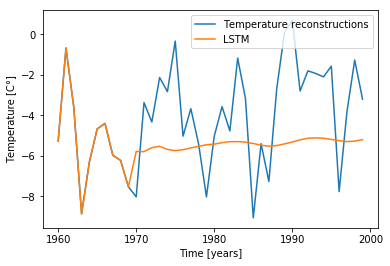

In [14]:
my_xticks = [ 1960, 1970, 1980, 1990, 2000]

x= [0, 10, 20, 30, 40]


pyplot.figure()
pyplot.plot(T_test[:batch_s+30,0], label='Temperature reconstructions')
pyplot.plot(T_predict_sc[:30+batch_s], label='LSTM')
pyplot.legend()
pyplot.ylabel("Temperature [C°]")
pyplot.xlabel("Time [years]")
pyplot.xticks(x, my_xticks)
pyplot.show()